<a href="https://colab.research.google.com/github/zey-o/DeepLearning_Wikiart_Emotions/blob/main/7a_three_classes_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

import pathlib
import matplotlib.pyplot as plt

from glob import glob
# import os
from google.colab import files

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, Activation, LeakyReLU
from tensorflow.keras import regularizers

from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import InputLayer


Again the same procedure: 
We'll first load the datasets as well as the images. For this '3-class' model, we will be trying to predict whether an artwork evokes 'positive', 'negative' or 'mixed' images as attributed by the authors of the study. 
1. Check & Load Data: We will first set the parameters of the modeling that we will be doing. 
2. Modeling: In this section we will try out a baseline model and then do transfer learning and data augmentation to come up with a final model. 
3. Predictions: Predict classes & check with the images assigned the predictions. 

## Check & Load Data from Directory

In [ ]:
data_dir = pathlib.Path("drive/MyDrive/DL/dataset_images")

In [ ]:
image_count = len(list(data_dir.glob('**/*.png')))
print(image_count)

4119


In [ ]:
df = pd.read_csv("drive/MyDrive/DL/path_prob.csv")

In [ ]:
df.head(3)

,Unnamed: 0,ID,emotion,path
0,0,58c6237dedc2c9c7dc0de1ae,happiness,dataset_images/58c6237dedc2c9c7dc0de1ae.png
1,1,577280dfedc2cb3880f28e76,anticipation,dataset_images/577280dfedc2cb3880f28e76.png
2,2,57727f2dedc2cb3880ed5fa9,happiness,dataset_images/57727f2dedc2cb3880ed5fa9.png


In [ ]:
df.path = "drive/MyDrive/DL/" + df.path
df.head(3)

,Unnamed: 0,ID,emotion,path
0,0,58c6237dedc2c9c7dc0de1ae,happiness,drive/MyDrive/DL/dataset_images/58c6237dedc2c9...
1,1,577280dfedc2cb3880f28e76,anticipation,drive/MyDrive/DL/dataset_images/577280dfedc2cb...
2,2,57727f2dedc2cb3880ed5fa9,happiness,drive/MyDrive/DL/dataset_images/57727f2dedc2cb...


In [ ]:
df.emotion.value_counts()

happiness           1102
surprise             822
anticipation         520
trust                478
fear                 358
sadness              226
humility             184
love                 114
disgust              101
optimism              62
arrogance             52
anger                 36
gratitude             14
pessimism             10
shame                  7
disagreeableness       7
neutral                5
agreeableness          5
shyness                2
Name: emotion, dtype: int64

For this 3-classes problem, we will tackle with identifying positive, negative & mixed emotions as per the description given by the authors of this study. 

In [ ]:
positive_emotions = ['gratitude', 'happiness', 'humility', 'love', 'optimism', 'trust']
negative_emotions = ['anger', 'arrogance', 'disgust', 'fear', 'pessimism', 'regret', 'sadness', 'shame']
mixed_emotions = ['agreeableness', 'anticipation', 'disagreeableness', 'shyness', 'surprise', 'neutral']

In [ ]:
df["emotion"] = df.emotion.apply(lambda x: "positive" if (x in positive_emotions) \
                                 else ("negative" if x in negative_emotions else "mixed"))
df.head(5)

,Unnamed: 0,ID,emotion,path
0,0,58c6237dedc2c9c7dc0de1ae,positive,drive/MyDrive/DL/dataset_images/58c6237dedc2c9...
1,1,577280dfedc2cb3880f28e76,mixed,drive/MyDrive/DL/dataset_images/577280dfedc2cb...
2,2,57727f2dedc2cb3880ed5fa9,positive,drive/MyDrive/DL/dataset_images/57727f2dedc2cb...
3,3,58d1240cedc2c94f900fc610,negative,drive/MyDrive/DL/dataset_images/58d1240cedc2c9...
4,4,57727de7edc2cb3880e91f26,positive,drive/MyDrive/DL/dataset_images/57727de7edc2cb...


In [ ]:
df.emotion.value_counts()

positive    1954
mixed       1361
negative     790
Name: emotion, dtype: int64

Again 'negative' emotions are less than the other two. We'll adjust this in the class_weight argument while training the model. 



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

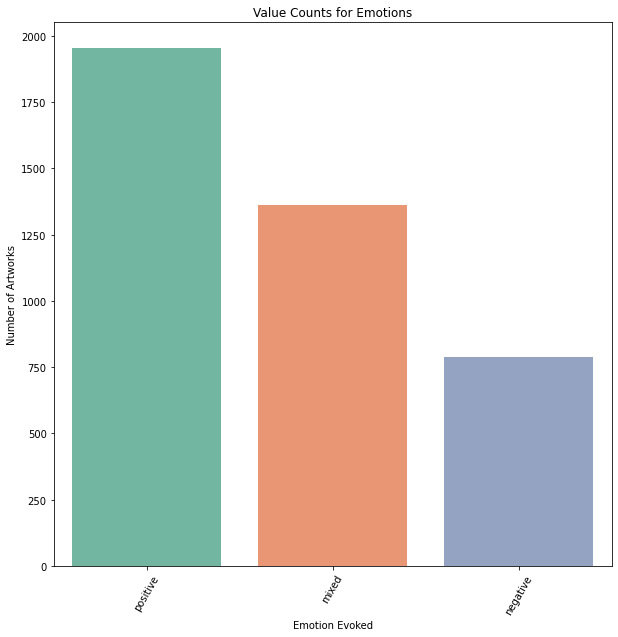

In [ ]:
emotion_3_class_count_plt = plt.figure(figsize=(10, 10))


sns.countplot(df.emotion, palette = "Set2")
plt.xlabel('Emotion Evoked')
plt.ylabel('Number of Artworks')
plt.xticks(rotation=60)
plt.title('Value Counts for Emotions')
plt.savefig("Value Counts for 3 Class.png", bbox_inches='tight', dpi = 250)
emotion_3_class_count_plt.savefig("Value Counts for 3 Class.png", bbox_inches='tight', dpi = 250)
files.download("Value Counts for 3 Class.png") 


In [ ]:
image_count = len(df)
image_count

4105

## Modeling 

We will first set parameters and then run very much similar models to the one we had with the binary class problem, except the last one will have  
1. Baseline 
2. Transfer Learning with MobileNet & Data Augmentation 
3. Transfer Learning with Data Augmentation Getting Rid of Dense Layers but adding more Dropouts & Regularization in the Layers
4. Back to Convolutions
5. Data Augmentation (with the Convolutions) 
6. Try Number 2 for a Final Round 
7. We will also try using LeakyReLu instead of ReLu to see if it makes a difference. 

In the end the 2nd model is the one that gets the highest accuracy with around 0.698.

### Set parameters

Let's set some of the parameters we will be using. 

- The image size we will resize all images to at the beginning of our training process. 
- We will set the number of epochs to a certain number so that we can keep tweaking it later. 
- Batch size will be 32. 
- The emotions we will be working with. 
- We will split the data into 3: train - validation - test (60% - 20% - 20%) 

In [ ]:
img_height = 180
img_width = 180

In [ ]:
epochs = 100
batch_size = 32

In [ ]:
val_set_start = int((6)*image_count//10)
test_set_start = int(8*image_count//10)

In [ ]:
datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
                                        dataframe = df[:val_set_start],
                                        x_col = "path",
                                        y_col = "emotion",
                                        batch_size = 32,
                                        interpolation = 'bilinear',
                                        seed = 42,
                                        shuffle = True,
                                        class_mode = "categorical",
                                        target_size = (img_height, img_width))

valid_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[(val_set_start):(test_set_start)],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            # # interpolation = 'bilinear',
                                            # seed = 42,
                                            shuffle = False,
                                            class_mode = "categorical",
                                            target_size = (img_height, img_width))

test_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[test_set_start:],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = False,
                                            class_mode = "categorical",
                                            target_size = (img_height, img_width))

Found 2463 validated image filenames belonging to 3 classes.
Found 821 validated image filenames belonging to 3 classes.
Found 821 validated image filenames belonging to 3 classes.


In [ ]:
class_names = train_generator.class_indices
print(class_names)

{'mixed': 0, 'negative': 1, 'positive': 2}


In [ ]:
num_classes = len(class_names)
num_classes

3

In [ ]:
images, labels = next(train_generator)
print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

float32 (32, 180, 180, 3)
float32 (32, 3)


In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

### 1. Baseline

Let's start with the same baseline we have been using and we will go from there. Order of business: create Sequantial layers with 1 set of hidden layer, compile and then fit model & lastly plot history.

In [ ]:
model_tc_baseline = Sequential([
    layers.InputLayer(input_shape=(img_height, img_width,3)),
    layers.Dense(units = 20, activation = 'relu'), 
    layers.Flatten(),
    layers.Dense(units = num_classes, activation = 'softmax') 
])

In [ ]:
model_tc_baseline.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["accuracy"])
model_tc_baseline.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 180, 180, 20)      80        
                                                                 
 flatten_1 (Flatten)         (None, 648000)            0         
                                                                 
 dense_3 (Dense)             (None, 3)                 1944003   
                                                                 
Total params: 1,944,083
Trainable params: 1,944,083
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_tc_baseline = model_tc_baseline.fit(train_generator,
                    # steps_per_epoch=STEP_SIZE_TRAIN,
                    steps_per_epoch = 25, 
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks = EarlyStopping(monitor='val_loss', \
                                              mode='min', verbose=1, patience = 4,\
                                             restore_best_weights=True)
)

Epoch 1/100
25/25 [==============================] - 571s 23s/step - loss: 20.8019 - accuracy: 0.3887 - val_loss: 7.6036 - val_accuracy: 0.4425
Epoch 2/100
25/25 [==============================] - 213s 9s/step - loss: 3.6061 - accuracy: 0.4931 - val_loss: 2.4505 - val_accuracy: 0.4663
Epoch 3/100
25/25 [==============================] - 147s 6s/step - loss: 3.9667 - accuracy: 0.4525 - val_loss: 3.7789 - val_accuracy: 0.4775
Epoch 4/100
25/25 [==============================] - 116s 5s/step - loss: 1.9967 - accuracy: 0.5350 - val_loss: 1.8409 - val_accuracy: 0.4613
Epoch 5/100
25/25 [==============================] - 87s 3s/step - loss: 1.9616 - accuracy: 0.5525 - val_loss: 3.7587 - val_accuracy: 0.4675
Epoch 6/100
25/25 [==============================] - 74s 3s/step - loss: 2.0610 - accuracy: 0.5300 - val_loss: 4.2463 - val_accuracy: 0.3787
Epoch 7/100
25/25 [==============================] - 61s 2s/step - loss: 1.9402 - accuracy: 0.5600 - val_loss: 2.5551 - val_accuracy: 0.3988
Epoch 8

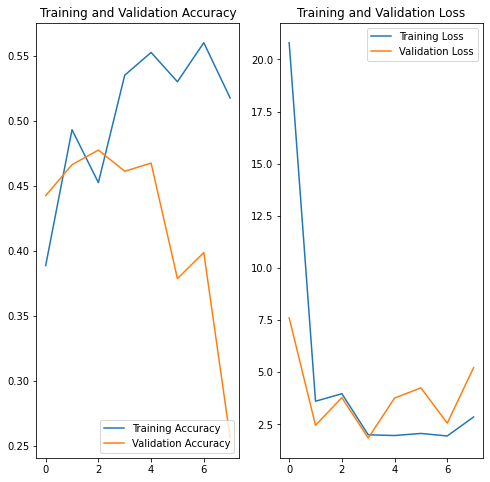

In [ ]:
number_of_epochs_it_ran = len(history_tc_baseline.history['loss'])

acc = history_tc_baseline.history['accuracy']
val_acc = history_tc_baseline.history['val_accuracy']

loss = history_tc_baseline.history['loss']
val_loss = history_tc_baseline.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
mean_val_acc = sum(val_acc)/len(val_acc)
mean_val_acc

0.41859374940395355

Now let's try the same convolutions we looked at but do it with augmented data. 

### 2. Transfer Learning w/ MobileNet w/ Data Augmentation

OK, let's transfer the MobileNet model trained with ImageNet weights, as this has been working for us. We will also do the data augmentation as we has been the order of business. 



In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
                                        dataframe = df[:val_set_start],
                                        x_col = "path",
                                        y_col = "emotion",
                                        batch_size = 32,
                                        interpolation = 'bilinear',
                                        seed = 42,
                                        shuffle = True,
                                        class_mode = "categorical",
                                        target_size = (img_height, img_width))

valid_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[(val_set_start):(test_set_start)],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = True,
                                            class_mode = "categorical",
                                            target_size = (img_height, img_width))

test_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[test_set_start:],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = False,
                                            class_mode = "categorical",
                                            target_size = (img_height, img_width))

Found 2463 validated image filenames belonging to 3 classes.
Found 821 validated image filenames belonging to 3 classes.
Found 821 validated image filenames belonging to 3 classes.


In [ ]:
base_model = mobilenet_v2.MobileNetV2\
                (weights='imagenet', include_top=False, input_shape=(img_height, img_width,3)) 

for layer in base_model.layers:
    layer.trainable = False   

x = base_model.output
x = Flatten()(x) 
x = Dense(512, activation='relu')(x) 
x = Dense(50, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x) 

model_tc_mobilenet_aug = Model(inputs=base_model.input, outputs=predictions)
model_tc_mobilenet_aug.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model_tc_mobilenet_aug.summary()

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
history_tc_mobilenet_aug = model_tc_mobilenet_aug.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks = EarlyStopping(monitor='val_loss', \
                                              mode='min', verbose=1, patience = 4,\
                                             restore_best_weights=True)
)

We will save the model just in case, and if we stumble upon a better model, we will update that one as the model for this notebook. Our optimum model for this notebook will be called "model_three_classes"

In [ ]:
# from keras.models import load_model
MODEL_PATH = "drive/MyDrive/DL/model_three_classes.h5"
model_tc_mobilenet_aug.save(MODEL_PATH)

In [ ]:
number_of_epochs_it_ran = len(history_tc_mobilenet_aug.history['loss'])

acc = history_tc_mobilenet_aug.history['accuracy']
val_acc = history_tc_mobilenet_aug.history['val_accuracy']

loss = history_tc_mobilenet_aug.history['loss']
val_loss = history_tc_mobilenet_aug.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from google.colab import files
#images_dir = '/content/gdrive/MyDrive/DL'
plt.savefig("Three_Classes_Model_Plots.png", bbox_inches='tight', dpi = 250)
files.download("Three_Classes_Model_Plots.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [ ]:
mean_val_acc = sum(val_acc)/len(val_acc)
mean_val_acc

### 3. Transfer Learning + Data Augmentation + Less Complex with more Dropouts + Regularization


Make it less complex and try more dropouts. 

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator=datagen.flow_from_dataframe(
                                        dataframe = df[:val_set_start],
                                        x_col = "path",
                                        y_col = "emotion",
                                        batch_size = 32,
                                        interpolation = 'bilinear',
                                        seed = 42,
                                        shuffle = True,
                                        class_mode = "categorical",
                                        target_size = (img_height, img_width))

valid_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[(val_set_start):(test_set_start)],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = True,
                                            class_mode = "categorical",
                                            target_size = (img_height, img_width))

test_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[test_set_start:],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = True,
                                            class_mode = "categorical",
                                            target_size = (img_height, img_width))

Found 2463 validated image filenames belonging to 3 classes.
Found 821 validated image filenames belonging to 3 classes.
Found 821 validated image filenames belonging to 3 classes.


In [ ]:
base_model = mobilenet_v2.MobileNetV2\
                (weights='imagenet', include_top=False, input_shape=(img_height, img_width,3)) 

for layer in base_model.layers:
    layer.trainable = False   

In [ ]:
L2 = 50
DROP = 0.2

x = base_model.output
x = Flatten()(x) 
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(L2))(x) 
x = Dropout(DROP)(x)
x = Dense(200, activation='relu', kernel_regularizer=regularizers.l2(L2))(x)
x = Dropout(DROP)(x)
x = Dense(300, activation='relu', kernel_regularizer=regularizers.l2(L2))(x)
x = Dropout(DROP)(x)
x = Dense(50, activation='relu', kernel_regularizer=regularizers.l2(L2))(x)
x = Dropout(DROP)(x)
x = Dense(50, activation='relu', kernel_regularizer=regularizers.l2(L2))(x) 
x = Dropout(DROP)(x)
predictions = Dense(num_classes, activation='softmax')(x) 


model_tc_mobilenet_dropout_more_layers = Model(inputs=base_model.input, outputs=predictions)

model_tc_mobilenet_dropout_more_layers.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_tc_mobilenet_dropout_more_layers.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 90, 90, 32)   864         ['input_4[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 90, 90, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 90, 90, 32)   0           ['bn_Conv1[0][0]']         

In [ ]:
# lr = (ReduceLROnPlateau(factor=.5, patience=3, verbose=1))
es = (EarlyStopping(verbose=1, patience = 4, restore_best_weights=True))

history_tc_mobilenet_dropout_more_layers = model_tc_mobilenet_dropout_more_layers.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks = es
                    # callbacks = [es, lr]
)


# TAKING OUT THE FOLLOWING FROM LAST MODEL IN EARLYSTOPPING: 
# monitor='val_loss', mode='min', 

Epoch 1/100
76/76 [==============================] - 98s 1s/step - loss: 15936.2402 - accuracy: 0.4603 - val_loss: 2924.1472 - val_accuracy: 0.4675
Epoch 2/100
76/76 [==============================] - 93s 1s/step - loss: 1177.9221 - accuracy: 0.4792 - val_loss: 376.1109 - val_accuracy: 0.4663
Epoch 3/100
76/76 [==============================] - 94s 1s/step - loss: 197.6557 - accuracy: 0.4796 - val_loss: 89.8872 - val_accuracy: 0.4625
Epoch 4/100
76/76 [==============================] - 94s 1s/step - loss: 49.4075 - accuracy: 0.4796 - val_loss: 22.6075 - val_accuracy: 0.4688
Epoch 5/100
76/76 [==============================] - 93s 1s/step - loss: 12.2194 - accuracy: 0.4788 - val_loss: 5.6000 - val_accuracy: 0.4613
Epoch 6/100
76/76 [==============================] - 94s 1s/step - loss: 3.2566 - accuracy: 0.4817 - val_loss: 1.8643 - val_accuracy: 0.4663
Epoch 7/100
76/76 [==============================] - 94s 1s/step - loss: 1.4103 - accuracy: 0.4776 - val_loss: 1.1731 - val_accuracy: 0.

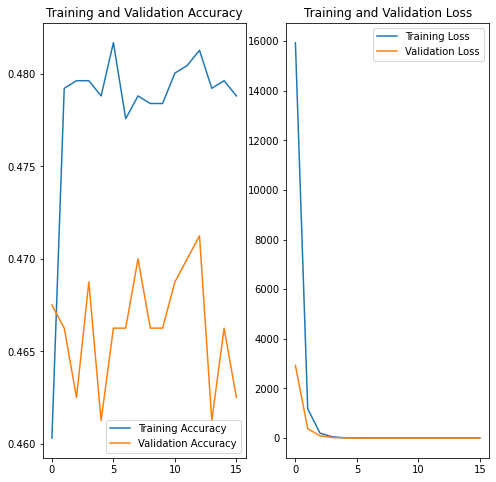

In [ ]:
number_of_epochs_it_ran = len(history_tc_mobilenet_dropout_more_layers.history['loss'])

acc = history_tc_mobilenet_dropout_more_layers.history['accuracy']
val_acc = history_tc_mobilenet_dropout_more_layers.history['val_accuracy']

loss = history_tc_mobilenet_dropout_more_layers.history['loss']
val_loss = history_tc_mobilenet_dropout_more_layers.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
mean_val_acc = sum(val_acc)/len(val_acc)
mean_val_acc

0.46632812730968

### 4. Using Convolutions

Let's return to no transfer learning but more convolutions. 

In [ ]:
model_tc_simple_cnn = Sequential()


model_tc_simple_cnn.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(img_height, img_width,3)))
model_tc_simple_cnn.add(Activation('relu'))

model_tc_simple_cnn.add(Conv2D(32, (3, 3)))
model_tc_simple_cnn.add(Activation('relu'))
model_tc_simple_cnn.add(MaxPool2D(pool_size=(2, 2)))
model_tc_simple_cnn.add(Dropout(0.25))

model_tc_simple_cnn.add(Conv2D(64, (3, 3), padding='same'))
model_tc_simple_cnn.add(Activation('relu'))

model_tc_simple_cnn.add(Conv2D(64, (3, 3)))
model_tc_simple_cnn.add(Activation('relu'))
model_tc_simple_cnn.add(MaxPool2D(pool_size=(2, 2)))
model_tc_simple_cnn.add(Dropout(0.25))

model_tc_simple_cnn.add(Flatten())
model_tc_simple_cnn.add(Dense(512))
model_tc_simple_cnn.add(Activation('relu'))
model_tc_simple_cnn.add(Dropout(0.5))

model_tc_simple_cnn.add(Dense(num_classes, activation='softmax'))

In [ ]:
model_tc_simple_cnn.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["accuracy"])
model_tc_simple_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 dropout_15 (Dropout)        (None, 89, 89, 32)        0         
                                                      

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [ ]:
history_tc_simple_cn = model_tc_simple_cnn.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks = EarlyStopping(monitor='val_loss', \
                                              mode='min', verbose=1, patience = 4,\
                                             restore_best_weights=True)
)

Epoch 1/100
76/76 [==============================] - 95s 1s/step - loss: 1.3745 - accuracy: 0.4759 - val_loss: 1.0335 - val_accuracy: 0.5125
Epoch 2/100
76/76 [==============================] - 94s 1s/step - loss: 1.0023 - accuracy: 0.5187 - val_loss: 0.9904 - val_accuracy: 0.5562
Epoch 3/100
76/76 [==============================] - 94s 1s/step - loss: 0.9854 - accuracy: 0.5496 - val_loss: 0.9991 - val_accuracy: 0.5188
Epoch 4/100
76/76 [==============================] - 94s 1s/step - loss: 0.9972 - accuracy: 0.5376 - val_loss: 1.0067 - val_accuracy: 0.5150
Epoch 5/100
76/76 [==============================] - 93s 1s/step - loss: 0.9802 - accuracy: 0.5467 - val_loss: 1.0378 - val_accuracy: 0.4762
Epoch 6/100
76/76 [==============================] - 93s 1s/step - loss: 0.9701 - accuracy: 0.5557 - val_loss: 0.9892 - val_accuracy: 0.5425
Epoch 7/100
76/76 [==============================] - 94s 1s/step - loss: 0.9662 - accuracy: 0.5520 - val_loss: 0.9696 - val_accuracy: 0.5500
Epoch 8/100
7

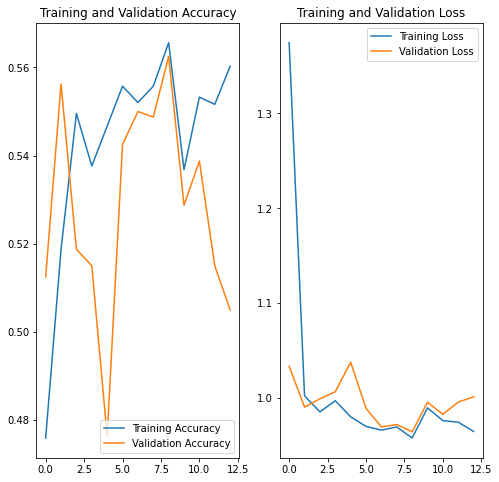

In [ ]:
number_of_epochs_it_ran = len(history_tc_simple_cn.history['loss'])

acc = history_tc_simple_cn.history['accuracy']
val_acc = history_tc_simple_cn.history['val_accuracy']

loss = history_tc_simple_cn.history['loss']
val_loss = history_tc_simple_cn.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
mean_val_acc = sum(val_acc)/len(val_acc)
mean_val_acc

0.5284615342433636

### 5. Data Augmentation + CNN's

One last try with data augmentation + CNN's. 

In [ ]:
train_generator.reset()
valid_generator.reset()
test_generator.reset()

In [ ]:
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
plt.figure(figsize=(10, 10))
images, labels = next(train_generator)
augmented_images = data_augmentation(images)

for i in range(0, 9): 
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_images[i])
  plt.axis("off")

In [ ]:
model_tc_aug_cnn = Sequential([
    data_augmentation, 
    layers.Conv2D(32, (3, 3), padding='same', activation = 'relu'), 
    layers.MaxPooling2D(pool_size=(2, 2)), 
    
    layers.Conv2D(64, (3, 3), padding='same', activation = 'relu'), 
    layers.MaxPooling2D(pool_size=(2, 2)), 
    layers.Dropout(0.25), 

    layers.Conv2D(64, (3, 3), padding='same', activation = 'relu'), 
    layers.MaxPooling2D(pool_size=(2, 2)), 

    layers.Conv2D(64, (3, 3), padding='same', activation = 'relu'), 
    layers.MaxPooling2D(pool_size=(2, 2)), 
    layers.Dropout(0.25), 
    layers.Flatten(),
    layers.Dense(512, activation = 'relu'), 
    layers.Dropout(0.5), 
    layers.Dense(num_classes, activation='softmax')])

In [ ]:
model_tc_aug_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_tc_aug_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 45, 45, 64)       

In [ ]:
history_tc_aug_cnn = model_tc_aug_cnn.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks = EarlyStopping(monitor='val_loss', \
                                              mode='min', verbose=1, patience = 4,\
                                             restore_best_weights=True)
)

Epoch 1/100
76/76 [==============================] - 1201s 16s/step - loss: 0.6145 - accuracy: 0.4751 - val_loss: 0.6010 - val_accuracy: 0.4675
Epoch 2/100
76/76 [==============================] - 75s 985ms/step - loss: 0.5848 - accuracy: 0.5228 - val_loss: 0.5952 - val_accuracy: 0.5225
Epoch 3/100
76/76 [==============================] - 76s 997ms/step - loss: 0.5723 - accuracy: 0.5594 - val_loss: 0.5856 - val_accuracy: 0.5337
Epoch 4/100
76/76 [==============================] - 75s 995ms/step - loss: 0.5648 - accuracy: 0.5640 - val_loss: 0.5986 - val_accuracy: 0.4762
Epoch 5/100
76/76 [==============================] - 75s 994ms/step - loss: 0.5614 - accuracy: 0.5689 - val_loss: 0.5860 - val_accuracy: 0.5113
Epoch 6/100
76/76 [==============================] - 76s 1s/step - loss: 0.5549 - accuracy: 0.5681 - val_loss: 0.5767 - val_accuracy: 0.5350
Epoch 7/100
76/76 [==============================] - 75s 996ms/step - loss: 0.5540 - accuracy: 0.5747 - val_loss: 0.5851 - val_accuracy: 0.

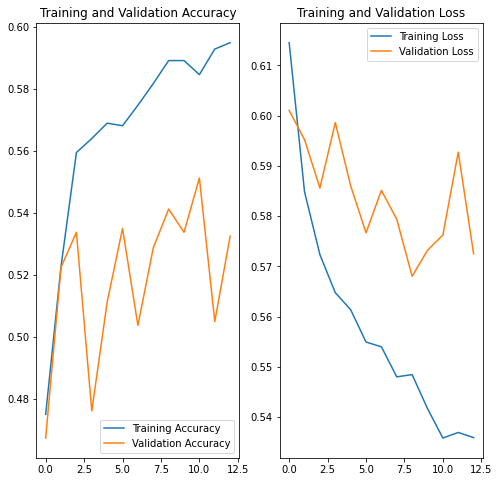

In [ ]:
number_of_epochs_it_ran = len(history_tc_aug_cnn.history['loss'])

acc = history_tc_aug_cnn.history['accuracy']
val_acc = history_tc_aug_cnn.history['val_accuracy']

loss = history_tc_aug_cnn.history['loss']
val_loss = history_tc_aug_cnn.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
mean_val_acc = sum(val_acc)/len(val_acc)
mean_val_acc

0.5186538489965292

### 6. One more try with transfer Learning (MobileNet) w/ Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
                                        dataframe = df[:val_set_start],
                                        x_col = "path",
                                        y_col = "emotion",
                                        batch_size = 32,
                                        interpolation = 'bilinear',
                                        # seed = 42,
                                        shuffle = True,
                                        class_mode = "categorical",
                                        target_size = (224, 224))

valid_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[(val_set_start):(test_set_start)],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            # seed = 42,
                                            shuffle = False,
                                            class_mode = "categorical",
                                            target_size = (224, 224))

test_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[test_set_start:],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            # seed = 42,
                                            shuffle = False,
                                            class_mode = "categorical",
                                            target_size = (224, 224))

Found 2463 validated image filenames belonging to 3 classes.
Found 821 validated image filenames belonging to 3 classes.
Found 821 validated image filenames belonging to 3 classes.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

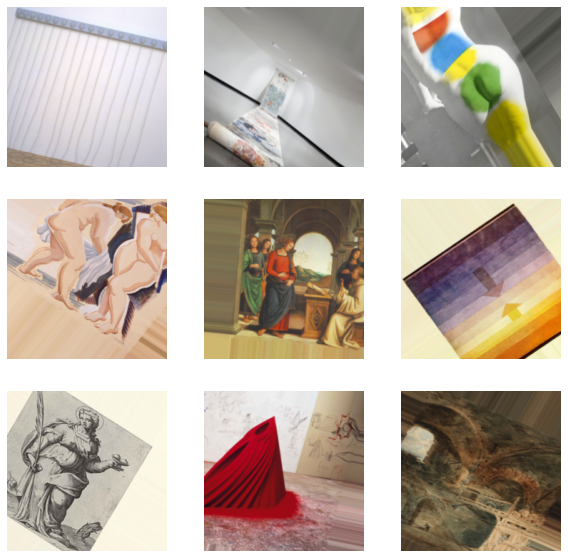

In [ ]:
distortion_plots = plt.figure(figsize=(10, 10))

x= train_generator.next()
plt.title('Distortion Images')

for i in range(0,9):
    ax = plt.subplot(3, 3, i + 1)
    image = x[0][i]
    plt.imshow(image)
    plt.axis("off")

distortion_plots.savefig("Distortion Images 3 Class.png", bbox_inches='tight', dpi = 250)
files.download("Distortion Images 3 Class.png") 



In [ ]:
base_model = mobilenet_v2.MobileNetV2\
                (weights='imagenet', include_top=False, input_shape=(224, 224,3)) 

for layer in base_model.layers:
    layer.trainable = False   

x = base_model.output
x = Flatten()(x) 
x = Dense(512, activation='relu')(x) 
x = Dense(50, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x) 

model_tc_mobilenet_aug = Model(inputs=base_model.input, outputs=predictions)
model_tc_mobilenet_aug.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model_tc_mobilenet_aug.summary()

In [ ]:
class_weights = {0: 1.,
                1: 1.,
                2: 2.}

history_tc_mobilenet_aug = model_tc_mobilenet_aug.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks = EarlyStopping(monitor='val_loss', \
                                              mode='min', verbose=1, patience = 20,\
                                             restore_best_weights=True), 
                    class_weight = class_weights
)

Epoch 1/100
76/76 [==============================] - 1248s 16s/step - loss: 6.4499 - accuracy: 0.5374 - val_loss: 2.2190 - val_accuracy: 0.5788
Epoch 2/100
76/76 [==============================] - 102s 1s/step - loss: 2.0583 - accuracy: 0.6269 - val_loss: 1.5955 - val_accuracy: 0.6125
Epoch 3/100
76/76 [==============================] - 101s 1s/step - loss: 1.8779 - accuracy: 0.6355 - val_loss: 1.8789 - val_accuracy: 0.5825
Epoch 4/100
76/76 [==============================] - 101s 1s/step - loss: 1.4176 - accuracy: 0.6602 - val_loss: 1.6884 - val_accuracy: 0.6350
Epoch 5/100
76/76 [==============================] - 101s 1s/step - loss: 1.4097 - accuracy: 0.6569 - val_loss: 1.4959 - val_accuracy: 0.6162
Epoch 6/100
76/76 [==============================] - 102s 1s/step - loss: 1.2053 - accuracy: 0.6742 - val_loss: 1.3088 - val_accuracy: 0.5738
Epoch 7/100
76/76 [==============================] - 101s 1s/step - loss: 1.1411 - accuracy: 0.6861 - val_loss: 1.6013 - val_accuracy: 0.5875
Epoc

In [ ]:
MODEL_PATH = "drive/MyDrive/DL/model_three_classes.h5"
model_tc_mobilenet_aug.save(MODEL_PATH)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


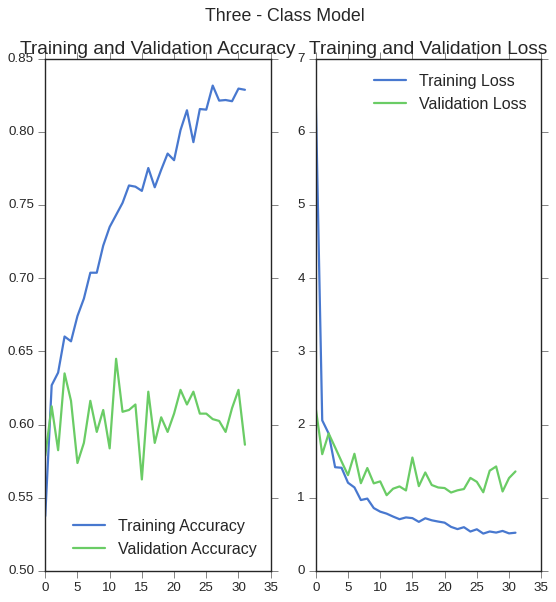

In [ ]:
number_of_epochs_it_ran = len(history_tc_mobilenet_aug.history['loss'])

acc = history_tc_mobilenet_aug.history['accuracy']
val_acc = history_tc_mobilenet_aug.history['val_accuracy']

loss = history_tc_mobilenet_aug.history['loss']
val_loss = history_tc_mobilenet_aug.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.style.use("seaborn-muted")
acc_plot = plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

acc_plot.suptitle('Three - Class Model', fontsize=16)
acc_plot.show()

In [ ]:
from google.colab import files
#images_dir = '/content/gdrive/MyDrive/DL'
acc_plot.savefig("Three_Classes_Model_Plots_2.png", bbox_inches='tight', dpi = 250)
files.download("Three_Classes_Model_Plots_2.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
mean_acc = sum(acc)/len(acc)
mean_acc

0.7498773988336325

In [ ]:
mean_val_acc = sum(val_acc)/len(val_acc)
mean_val_acc

0.6045703124254942

### 7. Not changing anything but trying Leaky ReLu instead

In [ ]:
datagen_7 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen_7 =ImageDataGenerator(rescale=1./255.)

train_generator_7=datagen_7.flow_from_dataframe(
                                        dataframe = df[:val_set_start],
                                        x_col = "path",
                                        y_col = "emotion",
                                        batch_size = 32,
                                        interpolation = 'bilinear',
                                        # seed = 42,
                                        shuffle = True,
                                        class_mode = "categorical",
                                        target_size = (224, 224))

valid_generator_7=test_datagen_7.flow_from_dataframe(
                                            dataframe = df[(val_set_start):(test_set_start)],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            # seed = 42,
                                            shuffle = False,
                                            class_mode = "categorical",
                                            target_size = (224, 224))

test_generator_7=test_datagen_7.flow_from_dataframe(
                                            dataframe = df[test_set_start:],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            # seed = 42,
                                            shuffle = False,
                                            class_mode = "categorical",
                                            target_size = (224, 224))

Found 2463 validated image filenames belonging to 3 classes.
Found 821 validated image filenames belonging to 3 classes.
Found 821 validated image filenames belonging to 3 classes.


In [ ]:
base_model_7 = mobilenet_v2.MobileNetV2\
                (weights='imagenet', include_top=False, input_shape=(224, 224,3)) 

for layer in base_model_7.layers:
    layer.trainable = False   

x_7 = base_model_7.output
x_7 = Flatten()(x_7) 
x_7 = Dense(512)(x_7)
x_7 = LeakyReLU(alpha=0.3)(x_7)
x_7 = Dense(50)(x_7)
x_7 = LeakyReLU(alpha=0.3)(x_7)
predictions_7 = Dense(num_classes, activation='softmax')(x_7) 

model_tc_mobilenet_aug_7 = Model(inputs=base_model_7.input, outputs=predictions_7)
model_tc_mobilenet_aug_7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model_tc_mobilenet_aug_7.summary()

In [ ]:
class_weights = {0: 1.,
                1: 1.,
                2: 2.}

history_tc_mobilenet_aug_7 = model_tc_mobilenet_aug_7.fit(train_generator_7,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks = EarlyStopping(monitor='val_loss', \
                                              mode='min', verbose=1, patience = 20,\
                                             restore_best_weights=True), 
                    class_weight = class_weights
)

Epoch 1/100
76/76 [==============================] - 106s 1s/step - loss: 20.5861 - accuracy: 0.5463 - val_loss: 3.4542 - val_accuracy: 0.6112
Epoch 2/100
76/76 [==============================] - 102s 1s/step - loss: 3.3770 - accuracy: 0.6096 - val_loss: 2.0319 - val_accuracy: 0.5813
Epoch 3/100
76/76 [==============================] - 102s 1s/step - loss: 2.9029 - accuracy: 0.6113 - val_loss: 1.8658 - val_accuracy: 0.6012
Epoch 4/100
76/76 [==============================] - 101s 1s/step - loss: 2.0748 - accuracy: 0.6310 - val_loss: 1.9039 - val_accuracy: 0.5813
Epoch 5/100
76/76 [==============================] - 101s 1s/step - loss: 1.3393 - accuracy: 0.6652 - val_loss: 1.3890 - val_accuracy: 0.6162
Epoch 6/100
76/76 [==============================] - 102s 1s/step - loss: 1.0719 - accuracy: 0.6956 - val_loss: 1.4770 - val_accuracy: 0.5900
Epoch 7/100
76/76 [==============================] - 101s 1s/step - loss: 0.9841 - accuracy: 0.7051 - val_loss: 1.1561 - val_accuracy: 0.6150
Epoch

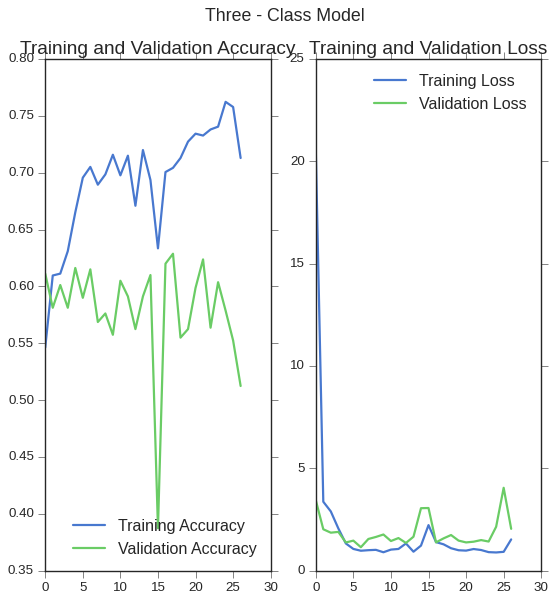

In [ ]:
number_of_epochs_it_ran_7 = len(history_tc_mobilenet_aug_7.history['loss'])

acc_7 = history_tc_mobilenet_aug_7.history['accuracy']
val_acc_7 = history_tc_mobilenet_aug_7.history['val_accuracy']

loss_7 = history_tc_mobilenet_aug_7.history['loss']
val_loss_7 = history_tc_mobilenet_aug_7.history['val_loss']

epochs_range_7 = range(number_of_epochs_it_ran_7)

plt.style.use("seaborn-muted")
acc_plot_7 = plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_7, acc_7, label='Training Accuracy')
plt.plot(epochs_range_7, val_acc_7, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_7, loss_7, label='Training Loss')
plt.plot(epochs_range_7, val_loss_7, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

acc_plot_7.suptitle('Three - Class Model', fontsize=16)
acc_plot_7.show()

In [ ]:
mean_acc_7 = sum(acc_7)/len(acc_7)
mean_acc_7

0.693374165782222

In [ ]:
mean_val_acc_7 = sum(val_acc_7)/len(val_acc_7)
mean_val_acc_7

0.5794907433015329